In [173]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import export_graphviz
import pydot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import linear_model


In [247]:
train = pd.read_csv('../data/trainPrepDone.csv')
test = pd.read_csv('../data/testPrepDone.csv')
testResults = pd.read_csv('../data/trueResults.csv')

In [248]:
train = train.fillna(0)
test = test.fillna(0)
train = train.drop('id', axis = 1)
test = test.drop('id', axis = 1)

In [287]:
train['culmative_workers_success'] = train.apply(lambda row: row.director_success + row.producer_success + row.actor1_success + row.actor2_success, axis = 1)
test['culmative_workers_success'] = test.apply(lambda row: row.director_success + row.producer_success + row.actor1_success + row.actor2_success, axis = 1)


In [249]:
train_rev_labels = np.array(train['revenue'])
test_labels = np.array(testResults['revenue'])

In [250]:
train_panda_features = train.drop((['revenue', 'log_revenue', 'budget']), axis = 1)
train_list = list(train.columns)
test_list = list(test.columns)

In [251]:
#remove unnamed
train_panda_features = train_panda_features.loc[:, ~train_panda_features.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

In [272]:
train

,Unnamed: 0,budget,popularity,runtime,revenue,has_collection,log_revenue,release_year,director_success,producer_success,...,Western,Thriller,Animation,Action,Mystery,Foreign,Science Fiction,Documentary,Family,adjusted_budget
0,0,14000000,6.575393,93.0,12314651,1,16.326300,2015,5.069332e+07,32768606.0,...,0,0,0,0,0,0,0,0,0,14000000.0
1,1,40000000,8.248895,113.0,95149435,1,18.370959,2004,1.138730e+08,0.0,...,0,0,0,0,0,0,0,0,1,40000000.0
2,2,3300000,64.299990,105.0,13092000,0,16.387512,2014,4.454357e+08,75496355.0,...,0,0,0,0,0,0,0,0,0,3300000.0
3,3,1200000,3.174936,122.0,16000000,0,16.588099,2012,0.000000e+00,0.0,...,0,1,0,0,0,0,0,0,0,1200000.0
4,4,0,1.148070,118.0,3923970,0,15.182615,2009,0.000000e+00,0.0,...,0,1,0,1,0,0,0,0,0,480672.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,0,9.853270,102.0,1596687,0,14.283442,1994,4.661607e+07,6804698.0,...,0,0,0,0,0,0,0,0,0,480672.1
2996,2996,0,3.727996,102.0,180590,0,12.103990,2013,0.000000e+00,0.0,...,0,0,0,0,0,0,0,0,0,480672.1
2997,2997,65000000,14.482345,120.0,89456761,0,18.309266,1996,5.730421e+07,0.0,...,0,1,0,1,1,0,0,0,0,65000000.0
2998,2998,42000000,15.725542,90.0,171963386,0,18.962792,2004,0.000000e+00,212684119.0,...,0,0,0,0,0,0,0,0,0,42000000.0


Test Combined Success over seperate success

In [252]:
train_features_mod2  = train_panda_features
test_features_mod2 = test.drop('budget', axis = 1)
train_features_mod2['culmative_workers_success'] = train.apply(lambda row: row.director_success + row.producer_success + row.actor1_success + row.actor2_success, axis = 1)
test_features_mod2['culmative_workers_success'] = test.apply(lambda row: row.director_success + row.producer_success + row.actor1_success + row.actor2_success, axis = 1)

train_features_mod2 = train_features_mod2.drop((['director_success', 'producer_success', 'actor1_success', 'actor2_success']), axis = 1)
test_features_mod2 = test_features_mod2.drop((['director_success', 'producer_success', 'actor1_success', 'actor2_success']), axis = 1)


In [262]:
train_features = np.array(train_panda_features)
test_features = np.array(test.drop('budget', axis = 1).fillna(0))

train_features_mod2np = np.array(train_features_mod2)
test_features_mod2np = np.array(test_features_mod2)

## Test accuracy/importance of features

Test Performance of only year and adjusted budget

In [316]:
train_budget_year_only = pd.DataFrame() 
train_budget_year_only['adjusted_budget'] = train['adjusted_budget']
train_budget_year_only['release_year'] = train['release_year']

test_budget_year_only = pd.DataFrame() 

test_budget_year_only['adjusted_budget'] = test['adjusted_budget']
test_budget_year_only['release_year'] = test['release_year']


In [317]:
lm_by = linear_model.LinearRegression()
lin_model_by = lm_by.fit(train_budget_year_only, train['revenue'])
lin_predictions_by = lm_by.predict(test_budget_year_only)
lin_predictions_by[lin_predictions_by < 0] = 0

In [318]:
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_by)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_by)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_by)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_by)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_by)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_by)))

Mean abs error 52912658.03960043
Median abs error 18372775.560792208
explained_variance_score 0.3132511190783297
mean_squared_error 1.1570459009393658e+16
mean_squared_log_error 97.59435172083244
r2_score 0.29103801664975104


end Test Performance of only year and adjusted budget

In [319]:
train_byp = train_budget_year_only.copy()
test_byp = test_budget_year_only.copy()
train_byp['popularity'] = train['popularity']
test_byp['popularity'] = test['popularity']

In [320]:
lm_byp = linear_model.LinearRegression()
lin_model_byp = lm_byp.fit(train_byp, train['revenue'])
lin_predictions_byp = lm_byp.predict(test_byp)
lin_predictions_byp[lin_predictions_byp < 0] = 0

In [321]:
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_byp)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_byp)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_byp)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_byp)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_byp)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_byp)))

Mean abs error 52506374.65842333
Median abs error 20262022.169546425
explained_variance_score 0.32876366302329174
mean_squared_error 1.138438665730138e+16
mean_squared_log_error 106.42816189762839
r2_score 0.3024393122836483


#### negligible/questionable gains from popularity -> drop it

In [322]:
train_byc = train_budget_year_only.copy()
test_byc = test_budget_year_only.copy()

train_byc['culmative_workers_success'] = train['culmative_workers_success']
test_byc['culmative_workers_success'] = test['culmative_workers_success']

In [323]:
lm_byc = linear_model.LinearRegression()
lin_model_byc = lm_byc.fit(train_byc, train['revenue'])
lin_predictions_byc = lm_byc.predict(test_byc)
lin_predictions_byc[lin_predictions_byc < 0] = 0

print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_byc)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_byc)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_byc)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_byc)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_byc)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_byc)))

Mean abs error 52413785.345142595
Median abs error 19339241.8471812
explained_variance_score 0.3213981147750862
mean_squared_error 1.1411863927832504e+16
mean_squared_log_error 107.74245355747992
r2_score 0.30075568502244965


In [ ]:
# questionable performance again, better than popularity but not by much -> keeping is questionable

In [324]:
train_byw = train_budget_year_only.copy()
test_byw = test_budget_year_only.copy()

train_byw[['director_success', 'producer_success', 'actor1_success', 'actor2_success']] = train[['director_success', 'producer_success', 'actor1_success', 'actor2_success']]
test_byw[['director_success', 'producer_success', 'actor1_success', 'actor2_success']] = test[['director_success', 'producer_success', 'actor1_success', 'actor2_success']]

In [325]:

train_budget_year_only.head()

,adjusted_budget,release_year
0,14000000.0,2015
1,40000000.0,2004
2,3300000.0,2014
3,1200000.0,2012
4,480672.1,2009


In [332]:
lm_byw = linear_model.LinearRegression()
lin_model_byw = lm_byw.fit(train_byw, train['revenue'])
lin_predictions_byw = lm_byw.predict(test_byw)
lin_predictions_byw[lin_predictions_byw < 0] = 0

print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_byw)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_byw)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_byw)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_byw)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_byw)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_byw)))

Mean abs error 52020409.9268007
Median abs error 18977317.41375494
explained_variance_score 0.32112925869461184
mean_squared_error 1.1400907658977488e+16
mean_squared_log_error 106.22162559604693
r2_score 0.30142701345386824


In [333]:
lm_byw = linear_model.LinearRegression()
lin_model_byw = lm_byw.fit(train_byw.drop(['release_year'], axis=1), train['revenue'])
lin_predictions_byw = lm_byw.predict(test_byw.drop(['release_year'], axis = 1))
lin_predictions_byw[lin_predictions_byw < 0] = 0

print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_byw)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_byw)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_byw)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_byw)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_byw)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_byw)))

Mean abs error 51735256.50980486
Median abs error 18960630.068850238
explained_variance_score 0.328194402856137
mean_squared_error 1.1264442586871886e+16
mean_squared_log_error 107.13466279122991
r2_score 0.30978869971881906


In [ ]:
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_byw)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_byw)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_byw)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_byw)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_byw)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_byw)))

dropping release_year leads to performance gains -> attempt to get inflation data (CPI) to replace release_year

### Replace release_year with CPI for that year

In [341]:
import csv
with open('dsfinal/inflation.csv', mode='r') as infile:
    reader = csv.reader(infile)
    with open('dsfinal/idkwhythis.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
        year_to_cpi = {int(rows[0]):rows[1] for rows in reader}

In [353]:
def inflation_for_year(year):
    if year in year_to_cpi.keys():
         return float(year_to_cpi[year])
    else:
 
        return float(year_to_cpi[1947])

In [354]:
train['cpi_on_release_year'] = train.apply(lambda row: inflation_for_year(int(row.release_year)), axis = 1)
test['cpi_on_release_year'] = test.apply(lambda row: inflation_for_year(int(row.release_year)), axis = 1)

In [356]:
train['market_ratio_to_2018'] = train.apply(lambda row: row.cpi_on_release_year/249.498, axis = 1)
test['market_ratio_to_2018'] = test.apply(lambda row: row.cpi_on_release_year/249.498, axis = 1)

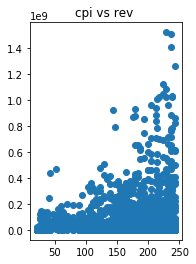

In [376]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 2)

plt.scatter(train['cpi_on_release_year'], train['revenue'])
plt.title('cpi vs rev ');

In [367]:
train_bm  = pd.DataFrame() 
train_bm['bud'] = train['adjusted_budget']
train_bm['infl'] = train['market_ratio_to_2018']

test_bm  = pd.DataFrame() 
test_bm['bud'] = test['adjusted_budget']
test_bm['infl'] =test['market_ratio_to_2018']

In [368]:
lm_bm = linear_model.LinearRegression()
lin_model_bm = lm_bm.fit(train_bm, train['revenue'])
lin_predictions_bm = lm_bm.predict(test_bm)
lin_predictions_bm[lin_predictions_bm < 0] = 0

print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_bm)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_bm)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_bm)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_bm)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_bm)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_bm)))

Mean abs error 52855070.02644414
Median abs error 18137746.631709933
explained_variance_score 0.315718970466748
mean_squared_error 1.1527440072433534e+16
mean_squared_log_error 100.3453433873788
r2_score 0.2936739354878981


In [370]:
train_bm[['director_success', 'producer_success', 'actor1_success', 'actor2_success']] = train[['director_success', 'producer_success', 'actor1_success', 'actor2_success']]
test_bm[['director_success', 'producer_success', 'actor1_success', 'actor2_success']] = test[['director_success', 'producer_success', 'actor1_success', 'actor2_success']]

In [371]:
lm_bm = linear_model.LinearRegression()
lin_model_bm = lm_bm.fit(train_bm, train['revenue'])
lin_predictions_bm = lm_bm.predict(test_bm)
lin_predictions_bm[lin_predictions_bm < 0] = 0

print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions_bm)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions_bm)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions_bm)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions_bm)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions_bm)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions_bm)))

Mean abs error 51899186.11440063
Median abs error 18931643.554969426
explained_variance_score 0.3290725166529225
mean_squared_error 1.1270000168154246e+16
mean_squared_log_error 107.1185858145974
r2_score 0.30944816751993454


## End feature testing

In [372]:
# Instantiate model=
rf2 = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf2.fit(np.array(train_bm), train_rev_labels);
firstForestPredictionMod2 = rf2.predict(np.array(test_bm))


print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], firstForestPredictionMod2)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], firstForestPredictionMod2)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], firstForestPredictionMod2)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], firstForestPredictionMod2)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], firstForestPredictionMod2)))
print("r2_score " + str(r2_score(testResults['revenue'], firstForestPredictionMod2)))

Mean abs error 54388274.53775129
Median abs error 22999567.755280357
explained_variance_score 0.31125195460766497
mean_squared_error 1.1720616161529104e+16
mean_squared_log_error 101.11680190653958
r2_score 0.28183736935427706


In [242]:
badValues = np.argwhere(np.isnan(test_features_mod2np))
print(badValues)

#np.isnan(X)

[]


In [256]:
# Instantiate model=
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_rev_labels);

In [257]:
# Use the forest's predict method on the test data
#before dropping budget
#Mean abs error 56314766.532770574
#Median abs error 27457243.644500002
#explained_variance_score 0.39389048033323626
#mean_squared_error 1.0980277322023664e+16
#mean_squared_log_error 105.41584460338858
#r2_score 0.32720048689186754"
firstForestPrediction = rf.predict(test_features)

ValueError: Number of features of the model must match the input. Model n_features is 23 and input n_features is 22 

In [ ]:
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], firstForestPrediction)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], firstForestPrediction)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], firstForestPrediction)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], firstForestPrediction)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], firstForestPrediction)))
print("r2_score " + str(r2_score(testResults['revenue'], firstForestPrediction)))

In [186]:
firstForestResults = {
    "mean_abs_error": mean_absolute_error(testResults['revenue'], firstForestPrediction),
    "median_abs_error": median_absolute_error(testResults['revenue'], firstForestPrediction),
    "explained_variance_score": explained_variance_score(testResults['revenue'], firstForestPrediction),
    "mean_squared_error ": mean_squared_error(testResults['revenue'], firstForestPrediction),
    "mean_squared_log_error": mean_squared_log_error(testResults['revenue'], firstForestPrediction),
    "r2_score": r2_score(testResults['revenue'], firstForestPrediction)
}


In [195]:
resultsDict = dict()
resultsDict['untunedForest'] =firstForestResults;
resultsDict

{'untunedForest': {'mean_abs_error': 56259074.08073511,
  'median_abs_error': 27683433.9875,
  'explained_variance_score': 0.3946882470293124,
  'mean_squared_error ': 1.0961478983582386e+16,
  'mean_squared_log_error': 105.39838154072294,
  'r2_score': 0.32835232601028097}}

In [85]:
#tree = rf.estimators_[5]
# Export the image to a dot file
#export_graphviz(tree, out_file = 'tree.dot', feature_names = train_list, rounded = True, precision = 1)
# Use dot file to create a graph
#(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
#graph.write_png('dsfinal/tree.png')

In [187]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [188]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfTuning = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfTuning, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_rev_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.3min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [193]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [194]:
best_random = rf_random.best_estimator_
# Use the forest's predict method on the test data
predictionsBestRandom = best_random.predict(test_features)
# Calculate the absolute errors
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], predictionsBestRandom)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], predictionsBestRandom)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], predictionsBestRandom)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], predictionsBestRandom)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], predictionsBestRandom)))
print("r2_score " + str(r2_score(testResults['revenue'], predictionsBestRandom)))

Mean abs error 49368785.381918505
Median abs error 20025426.768997185
explained_variance_score 0.4085365859424659
mean_squared_error 1.013696060415087e+16
mean_squared_log_error 102.30542619958375
r2_score 0.3788734146823831


In [196]:
tunedForestResults = {
    "mean_abs_error": mean_absolute_error(testResults['revenue'], predictionsBestRandom),
    "median_abs_error": median_absolute_error(testResults['revenue'], predictionsBestRandom),
    "explained_variance_score": explained_variance_score(testResults['revenue'], predictionsBestRandom),
    "mean_squared_error ": mean_squared_error(testResults['revenue'], predictionsBestRandom),
    "mean_squared_log_error": mean_squared_log_error(testResults['revenue'], predictionsBestRandom),
    "r2_score": r2_score(testResults['revenue'], predictionsBestRandom)
}
resultsDict['tunedForest'] = tunedForestResults
resultsDict


{'untunedForest': {'mean_abs_error': 56259074.08073511,
  'median_abs_error': 27683433.9875,
  'explained_variance_score': 0.3946882470293124,
  'mean_squared_error ': 1.0961478983582386e+16,
  'mean_squared_log_error': 105.39838154072294,
  'r2_score': 0.32835232601028097},
 'tunedForest': {'mean_abs_error': 49368785.381918505,
  'median_abs_error': 20025426.768997185,
  'explained_variance_score': 0.4085365859424659,
  'mean_squared_error ': 1.013696060415087e+16,
  'mean_squared_log_error': 102.30542619958375,
  'r2_score': 0.3788734146823831}}

Drop budget testing (Now irrelevant)

In [99]:
train_adjonly_features = np.array(train.drop('budget', axis = 1))
test_adjonly_features = np.array(test.drop('budget', axis = 1))
# Instantiate model=
rfAdjusted = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rfAdjusted.fit(train_adjonly_features, train_rev_labels);
test_adjonly_features = np.array(test.drop('budget', axis = 1))
# Use the forest's predict method on the test data
predictionsAdj = rfAdjusted.predict(test_adjonly_features)
# Calculate the absolute errors
errorsAdj = abs(predictionsAdj - test_labels)
print('Mean Absolute Error:', round(np.mean(errorsAdj), 2), 'dollars.')

Mean Absolute Error: 56259074.08 dollars.


In [169]:
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], predictionsAdj)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], predictionsAdj)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], predictionsAdj)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], predictionsAdj)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], predictionsAdj)))
print("r2_score " + str(r2_score(testResults['revenue'], predictionsAdj)))

Mean abs error 56259074.08073511
Median abs error 27683433.9875
explained_variance_score 0.3946882470293124
mean_squared_error 1.0961478983582386e+16
mean_squared_log_error 105.39838154072294
r2_score 0.32835232601028097


Begin Linear Regression Model
https://scikit-learn.org/stable/modules/model_evaluation.html

In [127]:
from sklearn import linear_model
X_lin_train = train.drop(['budget', 'revenue', 'log_revenue'], axis = 1)
X_lin_test = test.drop(['budget'], axis = 1)
y_train_labels = train['revenue']
lm = linear_model.LinearRegression()
lin_model = lm.fit(X_lin_train, y_train_labels)
lin_predictions = lm.predict(X_lin_test)

In [168]:
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_predictions)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_predictions)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_predictions)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_predictions)))
#print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_predictions)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_predictions)))

Mean abs error 53650211.95932021
Median abs error 25388492.5928815
explained_variance_score 0.36304657826241127
mean_squared_error 1.0645332789438754e+16
r2_score 0.34772369517089374


In [138]:
from scipy.stats import uniform as sp_rand
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
# prepare a uniform distribution to sample for the alpha parameter
param_grid = {'alpha': sp_rand()}
# create and fit a ridge regression model, testing random alpha values
lin_ridge_model = Ridge()
rsearch = RandomizedSearchCV(estimator=lin_ridge_model, param_distributions=param_grid, n_iter=100)
rsearch.fit(X_lin_train, y_train_labels)

C:\Users\ov78\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.06539e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\ov78\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.84278e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\ov78\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.02236e-20): result may not be accurate.
  overwrite_a=True).T
C:\Users\ov78\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.28766e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\ov78\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.79528e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\ov78\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.p

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='auto',
                                   tol=0.001),
                   iid='warn', n_iter=100, n_jobs=None,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000025A821DAA48>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [139]:
lin_ridge_predictions = rsearch.best_estimator_ .predict(X_lin_test)

In [220]:
lin_ridge_predictions[lin_ridge_predictions < 0] = 0

In [221]:
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], lin_ridge_predictions)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], lin_ridge_predictions)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], lin_ridge_predictions)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], lin_ridge_predictions)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], lin_ridge_predictions)))
print("r2_score " + str(r2_score(testResults['revenue'], lin_ridge_predictions)))
#Can't perform mean_squared_log_error due to negative

Mean abs error 49954618.850649625
Median abs error 19841585.12715906
explained_variance_score 0.3778371443837113
mean_squared_error 1.0533681198485598e+16
mean_squared_log_error 112.80768907868972
r2_score 0.35456497374956497


In [222]:
revMean = train['revenue'].mean()
predictMeanOnly = test.apply(lambda row: row.budget, axis = 1)
print("Mean abs error " + str(mean_absolute_error(testResults['revenue'], predictMeanOnly)))
print("Median abs error " + str(median_absolute_error(testResults['revenue'], predictMeanOnly)))
print("explained_variance_score " + str(explained_variance_score(testResults['revenue'], predictMeanOnly)))
print("mean_squared_error " + str(mean_squared_error(testResults['revenue'], predictMeanOnly)))
print("mean_squared_log_error " + str(mean_squared_log_error(testResults['revenue'], predictMeanOnly)))
print("r2_score " + str(r2_score(testResults['revenue'], predictMeanOnly)))


Mean abs error 43261821.94338336
Median abs error 10765848.5
explained_variance_score 0.2637414806194721
mean_squared_error 1.2667211339647546e+16
mean_squared_log_error 102.16210549099235
r2_score 0.223836213621061


In [223]:
averagePredict = {
    "mean_abs_error": mean_absolute_error(testResults['revenue'], predictMeanOnly),
    "median_abs_error": median_absolute_error(testResults['revenue'], predictMeanOnly),
    "explained_variance_score": explained_variance_score(testResults['revenue'], predictMeanOnly),
    "mean_squared_error ": mean_squared_error(testResults['revenue'], predictMeanOnly),
    "mean_squared_log_error": mean_squared_log_error(testResults['revenue'], predictMeanOnly),
    "r2_score": r2_score(testResults['revenue'], predictMeanOnly)
}

resultsDict['averagePredict'] = averagePredict
resultsDict

{'untunedForest': {'mean_abs_error': 56259074.08073511,
  'median_abs_error': 27683433.9875,
  'explained_variance_score': 0.3946882470293124,
  'mean_squared_error ': 1.0961478983582386e+16,
  'mean_squared_log_error': 105.39838154072294,
  'r2_score': 0.32835232601028097},
 'tunedForest': {'mean_abs_error': 49368785.381918505,
  'median_abs_error': 20025426.768997185,
  'explained_variance_score': 0.4085365859424659,
  'mean_squared_error ': 1.013696060415087e+16,
  'mean_squared_log_error': 102.30542619958375,
  'r2_score': 0.3788734146823831},
 'averagePredict': {'mean_abs_error': 43261821.94338336,
  'median_abs_error': 10765848.5,
  'explained_variance_score': 0.2637414806194721,
  'mean_squared_error ': 1.2667211339647546e+16,
  'mean_squared_log_error': 102.16210549099235,
  'r2_score': 0.223836213621061}}

In [210]:
x

10371947.632538013